# Panel Data 
Julian Hsu
29may2022

Let's do simulation experiments with panel data:
1. What happens if we apply cross-sectional data methods to panel data?
2. Difference in difference (DnD)
    - The importance of controlling for fixed effects
    - Experiment with applying ML models to DnD
3. Synthetic control
4. Synthetic difference-in-difference

In [4]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

from IPython.display import display    

import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error


In [31]:
import stnomics as st

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


First we need to create synthetic panel data, with endogeneous treatment selection and impact. We will be looking at variation in treatment effects, so allow the ATET to different from the ATEU.

In [414]:
def synth_panel(seed_number = 2123, 
                time_units = 10, 
                x_units = 100, 
                K_dim = 5,
               treatment_type = 'both',
               treatment_imp = 10):
    '''
    seed_number  random_number_set
    time_units   how many time periods?
    x_units      how many units?
    K_dim        how many covariates (assume uniform)
    treatment_type    how is treatment determined? {'X','Y', 'both'}
    treatment_imp     the level of treatment effect, constant for all post-treatment times
    '''
    ## Set the seed for random number
    xfun = np.random.RandomState(seed_number)
    
    ## Construct covariates, time-invariant fixed effects, and first period outcome
    X = xfun.uniform(low=0, high=1, size= (x_units, K_dim) )
    X_coef = xfun.uniform(low=-2, high=2, size = K_dim)
    x_list = ['x'+str(k) for k in range(K_dim)]
    
    
    fe = xfun.normal(0,1, size=x_units)
    
    output_df = pd.DataFrame(data=X, columns=x_list)
    output_df['fe'] = fe
    output_df['Y'] = np.dot(X,X_coef) + fe + xfun.normal(0,1, size=x_units)
    output_df['T'] = pd.to_datetime('2020/01/01')
    output_df['unitid'] =  np.arange(x_units).astype(int)

    decay = 0.60

    for t in range(1,time_units):    
        ## Create the panel by setting up an AR(1) type function.
        prev_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=t-1))
        prev_data = decay*( output_df.loc[(output_df['T']==prev_date)][[r for r in output_df.columns if 'x' in r ]]     )
        ## perturb it a little with AR(1)
        prev_data += xfun.normal(0,1, size=(x_units,K_dim))
        prev_data['Y'] = decay*np.dot(prev_data,X_coef) + fe + xfun.normal(0,1, size=x_units)
        prev_data['T'] = pd.to_datetime('2020/01/01') + pd.offsets.DateOffset(months=t)
        prev_data['unitid'] = np.arange(x_units).astype(int)
        output_df = pd.concat([ output_df, prev_data])
    output_df['unitid'] = 'unit' + output_df['unitid'].apply(str)
    

    '''
    Decide the treatment effect based either the (i) covariates, (ii) pre-trend outcome, or (iii) both.
    
    Assign treatment to happen at the third to last time period
    '''
    if treatment_type=='X':
        input_treatment = x_list[:]
    elif treatment_type=='Y':
        input_treatment = 'Y'
    else:
        input_treatment = x_list[:] + ['Y']
        
    output_df['treatment_latent'] = 0
    treatment_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=time_units-3))    
    
    latent_treatment = np.dot(output_df[input_treatment], 
                              xfun.uniform(-4,4, size=len(input_treatment))) +\
                             xfun.normal(0,1,size=len(output_df))
    output_df['treatment_latent'] = np.exp(latent_treatment) / (1+ np.exp(latent_treatment))
    
    ## First decide treatment in the treatment time, and then make it permanent.    
    treatment_latent_xsection = output_df.loc[(output_df['T'] == treatment_date)][['unitid','treatment_latent']]
    treatment_decision = (treatment_latent_xsection['treatment_latent'] >\
                          treatment_latent_xsection['treatment_latent'].quantile(q=0.75))
    treatment_ids = treatment_latent_xsection.loc[(treatment_decision==True)]['unitid']
    
    output_df['post'] = (output_df['T'] >= treatment_date).astype(float)
    output_df['treatment_units'] = (output_df['unitid'].isin(treatment_ids)).astype(float)
    
    output_df['treatment'] = 0
    output_df.loc[ (output_df['unitid'].isin(treatment_ids)) & (output_df['T'] >= treatment_date), 'treatment'  ] = 1

    '''
    Apply treatment effect
    '''
    output_df.loc[( output_df['treatment']==1) , 'Y'] = treatment_imp + output_df.loc[( output_df['treatment']==1) , 'Y']
    
    return output_df

# Applying xsectional method to panel data
What if we only use one cross-section? 

What if we use each period's data as a separate feature?

Let's graphically look at the trend in Y.

,x0,x1,x2,fe,Y,treatment_latent,post,treatment_units,treatment
count,100.000000,100.000000,100.000000,10.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,0.481920,-0.188598,0.317878,0.406068,0.405583,3.512732e-01,0.300000,0.300000,0.090000
std,1.105340,1.050906,0.978362,0.611201,1.545094,3.979350e-01,0.460566,0.460566,0.287623
min,-3.446708,-3.242972,-2.307697,-1.156746,-2.920028,2.330542e-09,0.000000,0.000000,0.000000
25%,0.003146,-0.878114,-0.177608,0.337736,-0.543010,1.985268e-03,0.000000,0.000000,0.000000
50%,0.446489,-0.080098,0.475485,0.536401,0.234493,1.458202e-01,0.000000,0.000000,0.000000
75%,0.947607,0.665084,0.909095,0.749621,1.126053,7.837571e-01,1.000000,1.000000,0.000000
max,3.310783,1.767722,2.787906,1.026768,4.737021,9.999129e-01,1.000000,1.000000,1.000000


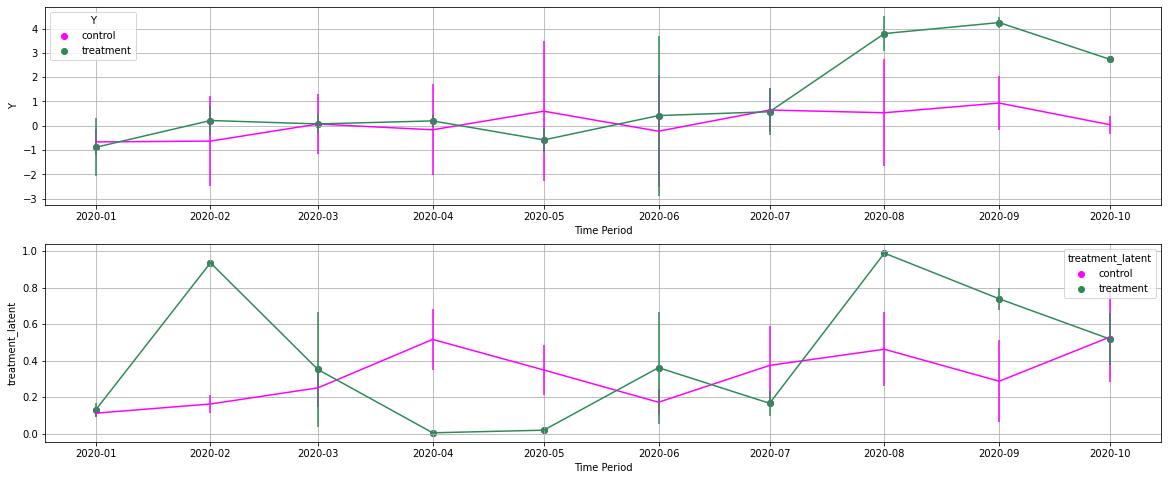

In [415]:
treatment_effect = 2.5
df = synth_panel(seed_number = 4527, 
                time_units = 10, 
                x_units = 10, 
                K_dim = 3,
               treatment_type = 'both',
               treatment_imp = treatment_effect)
# display(df.columns)
# display(df['T'].value_counts().sort_index())
display(df.describe())

df_mean = df.groupby(['treatment_units','T'])[['Y','treatment_latent']].mean().reset_index()
# df_mean.reset_index(inplace=True)

df_var = df.groupby(['treatment_units','T'])[['Y','treatment_latent']].var().reset_index()
# df_var.reset_index(inplace=True)


fig,ax = plt.subplots(ncols=1, nrows=2, figsize=(20,8))

for i, yt in zip(range(2), ['Y','treatment_latent']):

    ax[i].scatter(df_mean.loc[(df_mean['treatment_units']==1)]['T'], 
                  df_mean.loc[(df_mean['treatment_units']==1)][yt],
                  color='magenta',alpha=1, label='control')
    ax[i].errorbar(df_mean.loc[(df_mean['treatment_units']==0)]['T'], 
                  df_mean.loc[(df_mean['treatment_units']==0)][yt], 
                   yerr = df_var.loc[(df_var['treatment_units']==0)][yt],
                  color='magenta',alpha=1)

    ax[i].scatter(df_mean.loc[(df_mean['treatment_units']==1)]['T'], 
                  df_mean.loc[(df_mean['treatment_units']==1)][yt],
                  color='seagreen',alpha=1, label='treatment')
    ax[i].errorbar(df_mean.loc[(df_mean['treatment_units']==1)]['T'], 
                  df_mean.loc[(df_mean['treatment_units']==1)][yt], 
                   yerr = df_var.loc[(df_var['treatment_units']==1)][yt],              
                  color='seagreen',alpha=1)
    ax[i].legend(title=yt)
    ax[i].set_xlabel('Time Period')
    ax[i].set_ylabel(yt)
    ax[i].grid()

Use different pre-treatment cross-sections to estimate the impact on different post-reatment cross-sections.

In [416]:
split_name = 'splits'
feature_list =[x for x in df.columns if x[0]=='x'] + ['pre_Y']
outcome_name = 'Y'
treatment_name = 'treatment_units'
n_data_splits = 4
aux_dict = {'lower':0.001, 'upper':0.999}

print(feature_list)

['x0', 'x1', 'x2', 'pre_Y']


In [417]:
difference_in_months = 6
for di in range(difference_in_months+1):
    start = df['T'].min()+pd.offsets.DateOffset(months=di)
    x_df = df.loc[(df['T']==pd.to_datetime(start))]
    x_df['pre_Y'] = x_df['Y'].values
    
    treated_ids = df.loc[(df['treatment_units']==1)]['unitid']
    x_df['Y'] = df.loc[(df['T']==pd.to_datetime('2020-09-01'))]['Y'].values 
        
    print('\nUsing pre-treatment data from {1}'.format(di, start))
    a = st.ate.dml.dml_plm(x_df, 
                    split_name, feature_list, outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=100, random_state=27),
                    RandomForestClassifier(n_estimators=100, random_state=27),
                   n_data_splits,
                   aux_dict)
    print('  plm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(a['ATE TE'], a['ATE SE'], treatment_effect))
    b = st.ate.dml.dml_irm(x_df, 
                    split_name, feature_list, outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=100, random_state=27),
                    RandomForestClassifier(n_estimators=100, random_state=27),
                   n_data_splits,
                   {'lower':0.001, 'upper':0.999})
    print('  irm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(b['ATE TE'], b['ATE SE'], treatment_effect))
    print(' only using outcomes as covariates')
    a = st.ate.dml.dml_plm(x_df, 
                    split_name, ['pre_Y'], outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=100, random_state=27),
                    RandomForestClassifier(n_estimators=100, random_state=27),
                   n_data_splits,
                   aux_dict)  
    print('  plm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(a['ATE TE'], a['ATE SE'], treatment_effect))
    b = st.ate.dml.dml_irm(x_df, 
                    split_name, ['pre_Y'], outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=100, random_state=27),
                    RandomForestClassifier(n_estimators=100, random_state=27),
                   n_data_splits,
                   {'lower':0.001, 'upper':0.999})
    print('  irm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(b['ATE TE'], b['ATE SE'], treatment_effect))    


Using pre-treatment data from 2020-01-01 00:00:00
  plm-- 3.007[0.597] and True Impact is 2.500
  irm-- 2.266[0.966] and True Impact is 2.500
 only using outcomes as covariates
  plm-- 2.665[0.922] and True Impact is 2.500
  irm-- 1.576[  nan] and True Impact is 2.500

Using pre-treatment data from 2020-02-01 00:00:00
  plm-- 2.252[0.680] and True Impact is 2.500
  irm-- 2.483[0.688] and True Impact is 2.500
 only using outcomes as covariates
  plm-- 3.432[0.726] and True Impact is 2.500
  irm-- 2.465[3.899] and True Impact is 2.500

Using pre-treatment data from 2020-03-01 00:00:00
  plm-- 2.884[0.694] and True Impact is 2.500
  irm-- 4.210[1.514] and True Impact is 2.500
 only using outcomes as covariates
  plm-- 2.748[0.701] and True Impact is 2.500
  irm-- 3.432[1.252] and True Impact is 2.500

Using pre-treatment data from 2020-04-01 00:00:00
  plm-- 3.893[0.708] and True Impact is 2.500
  irm-- 2.770[0.639] and True Impact is 2.500
 only using outcomes as covariates
  plm-- 2.96

What if we use the different time periods' different features?

In [418]:
x_df = df.loc[(df['T']< pd.to_datetime('2020-08-01'))][[p for p in df.columns if p[0]=='x']+\
                                                       ['Y','T','unitid','treatment_units']]
x_df['T'] = x_df['T'].astype(str)

x_df = x_df.pivot_table(columns='T',
                index='unitid',
                values=[p for p in df.columns if p[0]=='x']+ ['Y'])
x_df.columns = ['_'.join(col) for col in x_df.columns]
x_df.reset_index(inplace=True)

treated_ids = df.loc[(df['treatment_units']==1)]['unitid']
x_df['treated'] = (x_df['unitid'].isin(treated_ids)).astype(float)
x_df['postY'] = df.loc[(df['T']==pd.to_datetime('2020-10-01'))]['Y'].values 

In [419]:
feature_x_name = [x for x in x_df.columns if x !='postY' and x != 'treated' and x !='unitid']
outcome_x_name = 'postY'
treatment_x_name = 'treated'
print('\nUsing all pre-treatment data')
a = st.ate.dml.dml_plm(x_df, 
                split_name, feature_x_name, outcome_x_name, treatment_x_name,
                RandomForestRegressor(n_estimators=100, random_state=27),
                RandomForestClassifier(n_estimators=100, random_state=27),
               n_data_splits,
               aux_dict)
print('  plm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(a['ATE TE'], a['ATE SE'], treatment_effect))
b = st.ate.dml.dml_irm(x_df, 
                split_name, feature_x_name, outcome_x_name, treatment_x_name,
                RandomForestRegressor(n_estimators=100, random_state=27),
                RandomForestClassifier(n_estimators=100, random_state=27),
               n_data_splits,
               aux_dict)
print('  irm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(b['ATE TE'], b['ATE SE'], treatment_effect))
print('only using pre-treatment outcomes')
a = st.ate.dml.dml_plm(x_df, 
                split_name, [y for y in feature_x_name if 'Y' in y], outcome_x_name, treatment_x_name,
                RandomForestRegressor(n_estimators=100, random_state=27),
                RandomForestClassifier(n_estimators=100, random_state=27),
               n_data_splits,
               aux_dict)
print('  plm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(a['ATE TE'], a['ATE SE'], treatment_effect))
b = st.ate.dml.dml_irm(x_df, 
                split_name, [y for y in feature_x_name if 'Y' in y], outcome_x_name, treatment_x_name,
                RandomForestRegressor(n_estimators=100, random_state=27),
                RandomForestClassifier(n_estimators=100, random_state=27),
               n_data_splits,
               aux_dict)
print('  irm-- {0:5.3f}[{1:5.3f}] and True Impact is {2:5.3f}'.format(b['ATE TE'], b['ATE SE'], treatment_effect))



Using all pre-treatment data
  plm-- 2.991[0.437] and True Impact is 2.500
  irm-- 2.779[0.557] and True Impact is 2.500
only using pre-treatment outcomes
  plm-- 2.873[0.424] and True Impact is 2.500
  irm-- 3.885[0.902] and True Impact is 2.500


# Difference in Difference

We can be really flexible with controlling for fixed effects and time fixed effects.
Our set up is that we have control units indexed by $i = 0,..., N_T-1$ and then treated units index by $i = N_T, ..., \mathbb{N}$.

$\text{(A)  } \hspace{1cm} Y_{it} = \rho_0 1\{ i \geq N_T, t \geq T^* \} + \rho_1 1\{ i \geq N_T \} + \rho_2 1\{ t \geq T^* \} + \epsilon_{it} $

$\text{(B)  } \hspace{1cm} Y_{it} = \rho_0 1\{ i \geq N_T, t \geq T^* \} + \tau_t + FE_i + \epsilon_{it}$


In [420]:
import statsmodels.api as sm

In [421]:
'''
Create the fixed effects
'''
for i in pd.get_dummies(df['unitid']).columns:
    df['fe_'+i] = (df['unitid']==i).astype(float)
for t, dt in zip( range(len(pd.get_dummies(df['T']).columns)), pd.get_dummies(df['T']).columns):
    df['t_'+str(t)] = (df['T']==dt).astype(float)
    

In [422]:
'''
Create lagged outcome
'''
dnd_data = df.merge(
    df.set_index(['unitid','T'])['Y'].shift(1).reset_index().rename(columns={'Y':'Y.l1'}), \
        how='left', \
        left_on = ['unitid','T'],    right_on = ['unitid','T'])

In [423]:
def show_dnd_est(ols_result, truth):
    display('{0:5.3f} [{1:5.3f}], ({2:5.3f}, {3:5.3f})'.format(ols_result.params.treatment,
                                                             ols_result.bse.treatment,
                                                             ols_result.conf_int().loc['treatment'][0],
                                                             ols_result.conf_int().loc['treatment'][1] ))
    display(' Bias: {0:5.3f}'.format(ols_result.params.treatment - truth))

In [424]:
## Estimate Equation A
dnd_modelA = sm.OLS(dnd_data['Y'], 
                    sm.add_constant(dnd_data[    ['post', 'treatment_units','treatment']] )).fit()
show_dnd_est(dnd_modelA, )

dnd_modelA = sm.OLS(dnd_data.loc[ pd.isna(dnd_data['Y.l1'])==False  ]['Y'], 
                   sm.add_constant(dnd_data.loc[ pd.isna(dnd_data['Y.l1'])==False  ][    ['post', 'treatment_units','treatment', 'Y.l1']] )).fit()
show_dnd_est(dnd_modelA)

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


'3.027 [0.557], (1.922, 4.133)'

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


'3.056 [0.565], (1.934, 4.177)'

In [425]:
## Estimate Equation B
fe_te = [x for x in df.columns if x[0:3]=='fe_'] + \
                  [e for e in df.columns if e[0:2]=='t_' ]

## Estimate Equation A
dnd_modelB = sm.OLS(dnd_data['Y'], 
                    sm.add_constant(dnd_data[    ['post', 'treatment_units','treatment']\
                                            +fe_te] )).fit()
show_dnd_est(dnd_modelB)

dnd_modelB = sm.OLS(dnd_data.loc[ pd.isna(dnd_data['Y.l1'])==False  ]['Y'], 
                   sm.add_constant(dnd_data.loc[ pd.isna(dnd_data['Y.l1'])==False  ][    ['post', 'treatment_units','treatment', 'Y.l1']\
                                                                                    +fe_te] )).fit()
show_dnd_est(dnd_modelB)

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


'3.027 [0.513], (2.007, 4.048)'

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


'3.063 [0.513], (2.042, 4.083)'

# Synthetic Control

In [ ]:
## Abadie/Diamond/Hainmueller    
from typing import List
from operator import add
from toolz import reduce, partial

## Define loss function
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]+np.random.uniform(-0.005,0.005, X.shape[1])
#     w_start = np.ones(X.shape[1])

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         iter=50000, 
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

##  Doudchenko/Imbens (DI)
os.chdir(home_dir + '/SCM[1]')
try:
    import importlib
    importlib.reload(SCM_tuned_hsujulia)
except:
    import SCM_tuned_hsujulia as SCM
    